In [1]:
import matplotlib.pyplot as plt
import numpy as np
from time import time

from sklearn import datasets,svm,pipeline
from sklearn.kernel_approximation import (RBFSampler, Nystroem)
from sklearn.decomposition import PCA

In [2]:
digits = datasets.load_digits(n_class=9)
n_samples = len(digits.data)
data = digits.data/16.
data -= data.mean(axis=0)

In [3]:
# We learn the digits on the first half of the digits
data_train, targets_train = (data[:n_samples // 2],
                             digits.target[:n_samples // 2])


# Now predict the value of the digit on the second half:
data_test, targets_test = (data[n_samples // 2:],
                           digits.target[n_samples // 2:])

In [4]:
kernel_svm = svm.SVC(gamma=.2)
linear_svm = svm.LinearSVC()

In [5]:
feature_map_fourier = RBFSampler(gamma=.0,random_state=1)
feature_map_nystroem = Nystroem(gamma=.2,random_state=1)
fourier_approx_svm = pipeline.Pipeline([('feature_map',feature_map_fourier),
                                       ('svm',svm.LinearSVC())])
nystroem_approx_svm = pipeline.Pipeline([('feature_map',feature_map_nystroem),
                                        ('svm',svm.LinearSVC())])

In [6]:
kernel_svm_time = time()
kernel_svm.fit(data_train,targets_train)
kernel_svm_score = kernel_svm.score(data_test,targets_test)
kernel_svm_time = time() - kernel_svm_time

linear_svm_time = time()
linear_svm.fit(data_train,targets_train)
linear_svm_score = linear_svm.score(data_test,targets_test)
linear_svm_time = time() - linear_svm_time

In [7]:
sample_sizes = 30*np.arange(1,10)
fourier_scores = []
nystroem_scores = []
fourier_times = []
nystroem_times = []

for D in sample_sizes:
    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)
    start = time()
    nystroem_approx_svm.fit(data_train,targets_train)
    nystroem_times.append(time()-start)
    
    start = time()
    fourier_approx_svm.fit(data_train,targets_train)
    fourier_times.append(time()-start)
    
    fourier_score = fourier_approx_svm.score(data_test,targets_test)
    nystroem_score = nystroem_approx_svm.score(data_test,targets_test)
    nystroem_scores.append(nystroem_score)
    fourier_scores.append(fourier_score)

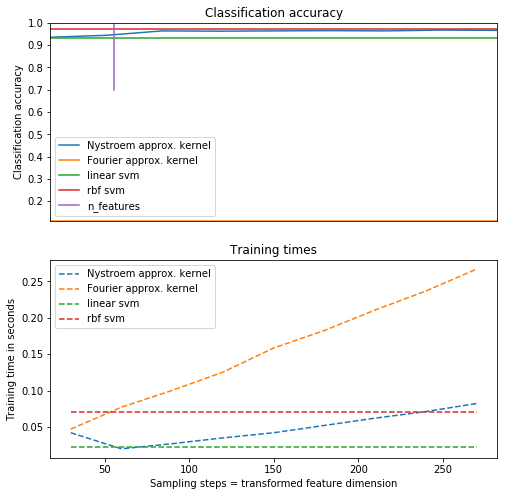

In [8]:
plt.figure(figsize=(8,8))
accuracy = plt.subplot(211)
timescale = plt.subplot(212)

accuracy.plot(sample_sizes,nystroem_scores,label='Nystroem approx. kernel')
timescale.plot(sample_sizes,nystroem_times,'--',label='Nystroem approx. kernel')

accuracy.plot(sample_sizes,fourier_scores,label='Fourier approx. kernel')
timescale.plot(sample_sizes,fourier_times,'--',label='Fourier approx. kernel')

# horizontal lines for exact rbf and linear kernels
accuracy.plot([sample_sizes[0],sample_sizes[-1]],[linear_svm_score,linear_svm_score],label='linear svm')
timescale.plot([sample_sizes[0],sample_sizes[-1]],[linear_svm_time,linear_svm_time],'--',label='linear svm')

accuracy.plot([sample_sizes[0],sample_sizes[-1]],[kernel_svm_score,kernel_svm_score],label='rbf svm')
timescale.plot([sample_sizes[0],sample_sizes[-1]],[kernel_svm_time,kernel_svm_time],'--',label='rbf svm')

# vertical line for dataset dimensionality = 64
accuracy.plot([64,64],[0.7,1],label='n_features')

# legends and labels
accuracy.set_title('Classification accuracy')
timescale.set_title('Training times')
accuracy.set_xlim(sample_sizes[0],sample_sizes[-1])
accuracy.set_xticks(())
accuracy.set_ylim(np.min(fourier_scores),1)
timescale.set_xlabel('Sampling steps = transformed feature dimension')
accuracy.set_ylabel('Classification accuracy')
timescale.set_ylabel('Training time in seconds')
accuracy.legend(loc='best')
timescale.legend(loc='best')

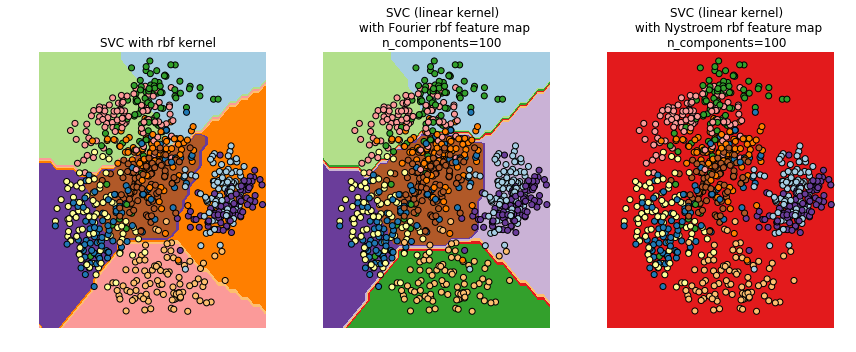

In [12]:
pca = PCA(n_components=8).fit(data_train)

X = pca.transform(data_train)

# generate grid along first two principal components
multiples = np.arange(-2,2,0.1)
# steps along first component
first = multiples[:,np.newaxis] * pca.components_[0,:]
# steps along second componnet
second = multiples[:,np.newaxis] * pca.components_[1,:]
# combine
grid = first[np.newaxis,:,:] + second[:,np.newaxis,:]
flat_grid = grid.reshape(-1,data.shape[-1])

# title for the plots
titles = ['SVC with rbf kernel','SVC (linear kernel)\n with Fourier rbf feature map\n'
         'n_components=100','SVC (linear kernel)\n with Nystroem rbf feature map\n'
         'n_components=100']

plt.tight_layout()
plt.figure(figsize=(12,5))

# predict and plot
for i,clf in enumerate((kernel_svm,nystroem_approx_svm,fourier_approx_svm)):
    # plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min,xmax]x[y_min,y_max].
    plt.subplot(1,3,i+1)
    Z = clf.predict(flat_grid)
    
    # put the result into a color plot
    Z = Z.reshape(grid.shape[:-1])
    plt.contourf(multiples,multiples,Z,cmap=plt.cm.Paired)
    plt.axis('off')
    
    # plot also the training points
    plt.scatter(X[:,0],X[:,1],c=targets_train,cmap=plt.cm.Paired,
               edgecolors=(0,0,0))
    plt.title(titles[i])
    
plt.tight_layout()
plt.show()